# 11-14.프로젝트 : CIFAR-10 이미지 생성하기

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### STEP 0. 라이브러리 로드

In [ ]:
import os
import glob
import time

import PIL
import imageio
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras import layers
from IPython import display
import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

print("tensorflow", tf.__version__)
print("imageio", imageio.__version__)

tensorflow 2.9.2
imageio 2.9.0


### STEP 1. 작업환경 구성하기

In [ ]:
# base_path = "/home/evergrin/python/notebook/data/dcgan/"
base_path = "/content/drive/MyDrive/data/dcgan/"
sample_path = os.path.join(base_path, "generated_samples")
checkpoint_path = os.path.join(base_path, "training_checkpoints")
history_path = os.path.join(base_path, "training_history")

### STEP 2. 데이터셋 구성하기

In [ ]:
data_count = 5000 # all is 5000
def load_data(label=None):
    (train_x, train_y), (test_x, test_y) = tf.keras.datasets.cifar10.load_data()
    if label:
        df = pd.DataFrame(list(zip(train_x, train_y)), columns=['image', 'label']) 
        df = df[df['label']==label]
        train_x = np.array([i for i in list(df['image'])])
        df = pd.DataFrame(list(zip(test_x, test_y)), columns =['image', 'label']) 
        df = df[df['label']==label]
        test_x = np.array([i for i in list(df['image'])])
    return train_x[:data_count], test_x[:data_count]

In [ ]:
# 새 이미지만 로드함.
train_x, test_x = load_data(2) # 2 bird

170498071/170498071 [==============================] - 2s 0us/step


In [ ]:
print("shape:", train_x.shape)
print("max pixel:", train_x.max())
print("min pixel:", train_x.min())

shape: (5000, 32, 32, 3)
max pixel: 255
min pixel: 0


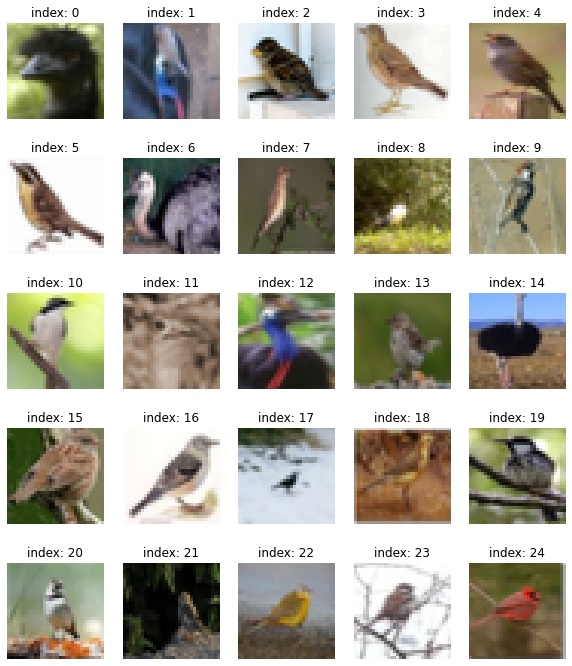

In [ ]:
plt.figure(figsize=(10, 12))

import random
imgs = random.choices(population=train_x, k=25)

for i in range(25):
    plt.subplot(5, 5, i+1)
    plt.imshow(imgs[i].reshape(32, 32, 3))
    plt.title(f'index: {i}')
    plt.axis('off')

plt.show()

In [ ]:
train_x = train_x.reshape(train_x.shape[0], 32, 32, 3).astype('float32')
train_x.shape

(5000, 32, 32, 3)

In [ ]:
train_x = (train_x - 127.5) / 127.5 # 이미지를 [-1, 1]로 정규화합니다.

print("max pixel:", train_x.max())
print("min pixel:", train_x.min())

max pixel: 1.0
min pixel: -1.0


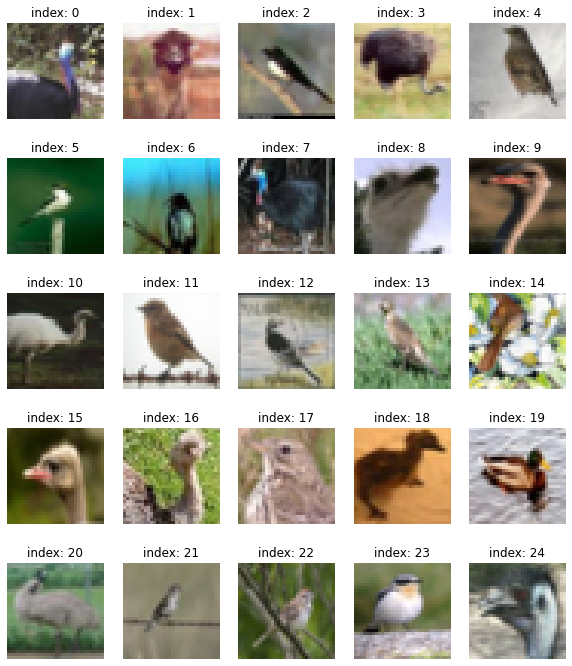

In [ ]:
plt.figure(figsize=(10, 12))

import random
imgs = random.choices(population=train_x, k=25)

for i in range(25):
    plt.subplot(5, 5, i+1)
    img = imgs[i]
    img = (img * 127.5) + 127.5   # reverse of normalization

    # float 타입인경우 warning발생.
    plt.imshow(img.reshape(32, 32, 3).astype(int))
    plt.title(f'index: {i}')
    plt.axis('off')

plt.show()

In [ ]:
BUFFER_SIZE = len(train_x)
BATCH_SIZE = 250

In [ ]:
train_dataset = tf.data.Dataset.from_tensor_slices(train_x).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

### STEP 3. 생성자 모델 구현하기

In [ ]:
def make_generator_model():
    
    # Start
    model = tf.keras.Sequential()

    # First: Dense layer
    model.add(layers.Dense(8*8*256, use_bias=False, input_shape=(100,)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    # Second: Reshape layer
    model.add(layers.Reshape((8, 8, 256)))

    # transpose layer out = (stride - 1) zero insertions.: 출력은 동일 크기.
    # Third: Conv2DTranspose layer
    model.add(layers.Conv2DTranspose(128*3, kernel_size=(5, 5), strides=(1, 1), padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    # Fourth: Conv2DTranspose layer : strides = 2, 1 zero insertion으로 출력은 두배가됨.
    model.add(layers.Conv2DTranspose(64*3, kernel_size=(5, 5), strides=(2, 2), padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    # Fifth: Conv2DTranspose layer(3ch로 최종 생성.)  : strides = 2, 1 zero insertion으로 출력은 두배가됨.
    model.add(layers.Conv2DTranspose(3, kernel_size=(5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh'))

    return model

In [ ]:
generator = make_generator_model()

generator.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 16384)             1638400   
                                                                 
 batch_normalization (BatchN  (None, 16384)            65536     
 ormalization)                                                   
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 16384)             0         
                                                                 
 reshape (Reshape)           (None, 8, 8, 256)         0         
                                                                 
 conv2d_transpose (Conv2DTra  (None, 8, 8, 384)        2457600   
 nspose)                                                         
                                                                 
 batch_normalization_1 (Batc  (None, 8, 8, 384)        1

In [ ]:
noise = tf.random.normal([1, 100])

In [ ]:
generated_image = generator(noise, training=False)
generated_image.shape

TensorShape([1, 32, 32, 3])

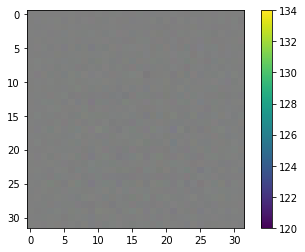

In [ ]:
image_g = generated_image[0].numpy()
image_r = (image_g * 127.5) + 127.5

plt.imshow(image_r.astype(int))
plt.colorbar()
plt.show()

### STEP 4. 판별자 모델 구현하기

In [ ]:
def make_discriminator_model():
    
    # Start
    model = tf.keras.Sequential()

    # First: Conv2D Layer
    model.add(layers.Conv2D(64*3, (5, 5), strides=(2, 2), padding='same', input_shape=[32, 32, 3]))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    # Second: Conv2D Layer
    model.add(layers.Conv2D(128*3, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    # Third: Flatten Layer
    model.add(layers.Flatten())

    # Fourth: Dense Layer
    model.add(layers.Dense(1))

    return model

In [ ]:
discriminator = make_discriminator_model()

discriminator.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 16, 16, 192)       14592     
                                                                 
 leaky_re_lu_3 (LeakyReLU)   (None, 16, 16, 192)       0         
                                                                 
 dropout (Dropout)           (None, 16, 16, 192)       0         
                                                                 
 conv2d_1 (Conv2D)           (None, 8, 8, 384)         1843584   
                                                                 
 leaky_re_lu_4 (LeakyReLU)   (None, 8, 8, 384)         0         
                                                                 
 dropout_1 (Dropout)         (None, 8, 8, 384)         0         
                                                                 
 flatten (Flatten)           (None, 24576)            

In [ ]:
decision = discriminator(generated_image, training=False)
decision

<tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[-4.291226e-05]], dtype=float32)>

### STEP 5. 손실함수와 최적화 함수 구현하기

In [ ]:
# from_logits = true : sigmod사용하여 0~1 사이의 값으로 정규화함.
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [ ]:
# generator는 loss가 1이 되길 원한다.
def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

In [ ]:
def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

In [ ]:
def discriminator_accuracy(real_output, fake_output):
    real_accuracy = tf.reduce_mean(tf.cast(tf.math.greater_equal(real_output, tf.constant([0.5])), tf.float32))
    fake_accuracy = tf.reduce_mean(tf.cast(tf.math.less(fake_output, tf.constant([0.5])), tf.float32))
    return real_accuracy, fake_accuracy

In [ ]:
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

### STEP 6. 훈련과정 상세 기능 구현하기

In [ ]:
noise_dim = 100
num_examples_to_generate = 16

seed = tf.random.normal([num_examples_to_generate, noise_dim])
seed.shape

TensorShape([16, 100])

In [ ]:
# tf.function 데코레이터를 tf 1.x 버전대처럼 그래프의 생성과 실행을 분리, 속도를 개선.
@tf.function
def train_step(images):  #(1) 입력데이터
    noise = tf.random.normal([BATCH_SIZE, noise_dim])  #(2) 생성자 입력 노이즈

    # GradientTape에서 variables을 watch하고 있음. 변경 사항을 기록해 gradient계산에 사용.
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:  #(3) tf.GradientTape() 오픈
        generated_images = generator(noise, training=True)  #(4) generated_images 생성

        #(5) discriminator 판별
        real_output = discriminator(images, training=True)
        fake_output = discriminator(generated_images, training=True)

        #(6) loss 계산
        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)

        #(7) accuracy 계산
        real_accuracy, fake_accuracy = discriminator_accuracy(real_output, fake_output) 
    
    #(8) gradient 계산
    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    #(9) 모델 학습
    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

    return gen_loss, disc_loss, real_accuracy, fake_accuracy  #(10) 리턴값

In [ ]:
def generate_and_save_images(model, epoch, it, sample_seeds):
    
    predictions = model(sample_seeds, training=False)

    fig = plt.figure(figsize=(4, 4))
    for i in range(predictions.shape[0]):
        plt.subplot(4, 4, i+1)
        image_g = predictions[i, :, :, :].numpy()
        image_r = (image_g * 127.5) + 127.5
        plt.imshow(image_r.astype(int))
        plt.axis('off')

    plt.savefig(os.path.join(sample_path, 'sample_epoch_{:04d}_iter_{:03d}.png'.format(epoch, it)))

    plt.show()

In [ ]:
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 15, 6    # matlab 차트의 기본 크기를 15,6으로 지정해 줍니다.

def draw_train_history(history, epoch):
    # summarize history for loss  
    plt.subplot(211)  
    plt.plot(history['gen_loss'])  
    plt.plot(history['disc_loss'])  
    plt.title('model loss')  
    plt.ylabel('loss')  
    plt.xlabel('batch iters')  
    plt.legend(['gen_loss', 'disc_loss'], loc='upper left')  

    # summarize history for accuracy  
    plt.subplot(212)  
    plt.plot(history['fake_accuracy'])  
    plt.plot(history['real_accuracy'])  
    plt.title('discriminator accuracy')  
    plt.ylabel('accuracy')  
    plt.xlabel('batch iters')  
    plt.legend(['fake_accuracy', 'real_accuracy'], loc='upper left')  
    
    # training_history 디렉토리에 epoch별로 그래프를 이미지 파일로 저장합니다.
    plt.savefig(os.path.join(history_path, 'train_history_{:04d}.png'.format(epoch)))
    plt.show()

In [ ]:
checkpoint_dir = checkpoint_path

checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

In [ ]:
def train(dataset, epochs, save_every):
    start = time.time()
    history = {'gen_loss':[], 'disc_loss':[], 'real_accuracy':[], 'fake_accuracy':[]}

    for epoch in range(epochs):
        epoch_start = time.time()
        for it, image_batch in enumerate(dataset):
            gen_loss, disc_loss, real_accuracy, fake_accuracy = train_step(image_batch)
            history['gen_loss'].append(gen_loss)
            history['disc_loss'].append(disc_loss)
            history['real_accuracy'].append(real_accuracy)
            history['fake_accuracy'].append(fake_accuracy)

            if it % 50 == 0:
                display.clear_output(wait=True)
                generate_and_save_images(generator, epoch+1, it+1, seed)
                print('Epoch {} | iter {}'.format(epoch+1, it+1))
                print('Time for epoch {} : {} sec'.format(epoch+1, int(time.time()-epoch_start)))

        if (epoch + 1) % save_every == 0:
            checkpoint.save(file_prefix=checkpoint_prefix)
            pass

        display.clear_output(wait=True)
        generate_and_save_images(generator, epochs, it, seed)
        print('Time for training : {} sec'.format(int(time.time()-start)))

        draw_train_history(history, epoch)

### STEP 7. 학습 과정 진행하기

In [ ]:
save_every = 5
EPOCHS = 50

# 사용가능한 GPU 디바이스 확인
tf.config.list_physical_devices("GPU")

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

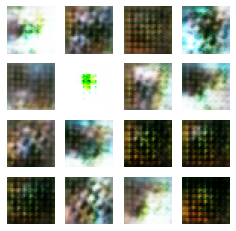

Time for training : 110 sec


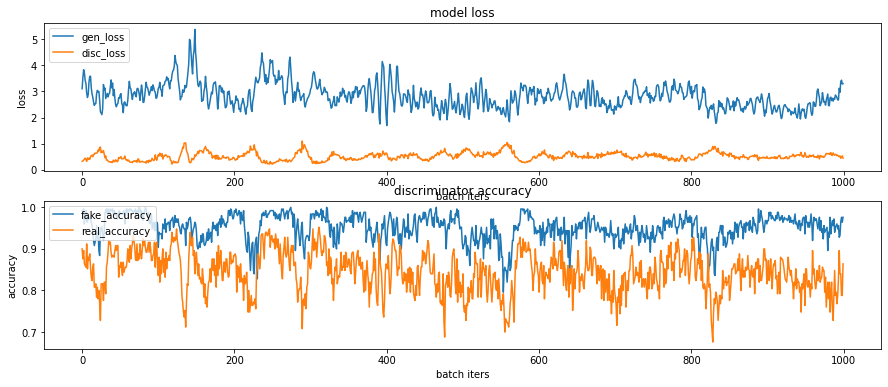

CPU times: user 1min 49s, sys: 1.85 s, total: 1min 51s
Wall time: 1min 50s


In [ ]:
%%time
train(train_dataset, EPOCHS, save_every)


In [ ]:
anim_file = os.path.join(base_path, 'dcgan_bird.gif')

with imageio.get_writer(anim_file, mode='I') as writer:
    filenames = glob.glob(os.path.join(sample_path, 'sample*.png'))
    filenames = sorted(filenames)
    last = -1
    for i, filename in enumerate(filenames):
        frame = 2*(i**0.5)
        if round(frame) > round(last):
            last = frame
        else:
            continue
        image = imageio.imread(filename)
        writer.append_data(image)
    image = imageio.imread(filename)
    writer.append_data(image)

# /content/drive/MyDrive/data/dcgan/dcgan_bird.gif 파일로 생성됨.

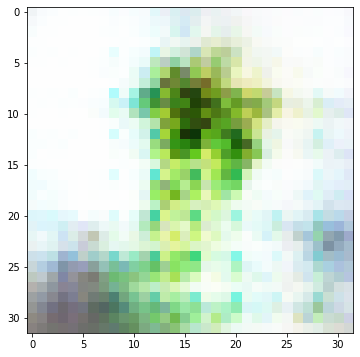

In [ ]:
checkpoint_dir = checkpoint_path

latest = tf.train.latest_checkpoint(checkpoint_dir)
checkpoint.restore(latest)

generator = checkpoint.generator
discriminator = checkpoint.discriminator
generator_optimizer = checkpoint.generator_optimizer
discriminator_optimizer = checkpoint.discriminator_optimizer

# 로드한 모델이 정상적으로 이미지를 생성하는지 확인해 봅니다. 
noise = tf.random.normal([1, 100])
generated_image = generator(noise, training=False)

np_generated = generated_image.numpy()
np_generated = (np_generated * 127.5) + 127.5   # reverse of normalization
np_generated = np_generated.astype(int)
plt.imshow(np_generated[0])
plt.show()  # 정상적으로 모델이 로드되었는지 확인.

### STEP 8. 회고  
---  

- 생성자와 판별자가 있는 GAN을 학습하였는데, loss와 accuracy는 이게 맞는지라는 의문이 든다.  
- 다양한 모델에 수동으로 step별 학습을 시킬 수 있도록, gradient를 manual하게 계산하여, 적용시키는 GradientTape을 알 수 있었다.


- test gif이미지: https://github.com/evergrin98/aiffel/blob/main/exp_node/data/dcgan/dcgan_bird.gif  
- test images: https://github.com/evergrin98/aiffel/blob/main/exp_node/data/dcgan/dcgan_bird.tgz  